## Tutorial: 2D Diffusion equation

In this tutorial we will show how to implement the 2D diffusion equation in raw, vectorized and symbolic Python before demonstrating the use of Devito.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from devito import *

First, let's define our initial condition (a ring) and a plotting utility function to visualise our data.

In [2]:
def plot(field):
    xvals = np.linspace(0, 1., field.shape[0])
    yvals = np.linspace(0, 1., field.shape[1])
    levels = np.linspace(-.2, 1.2, 21)
    cs = plt.contourf(xvals, yvals, field, levels=levels)
    plt.colorbar(cs)
    plt.show()

In [3]:
def ring_initial(spacing=0.01):
    """Initialise grid with initial condition ("ring")"""
    nx, ny = int(1 / spacing), int(1 / spacing)
    xx, yy = np.meshgrid(np.linspace(0., 1., nx, dtype=np.float32),
                         np.linspace(0., 1., ny, dtype=np.float32))
    ui = np.zeros((nx, ny), dtype=np.float32)
    r = (xx - .5)**2. + (yy - .5)**2.
    ui[np.logical_and(.05 <= r, r <= .1)] = 1.
    return ui

#### The diffusion equation

$ \frac{\partial u}{\partial t} = \alpha\nabla^2 u $

We will solve it using Finite Difference scheme with a Forward Euler timestespping, so we need two data buffers.

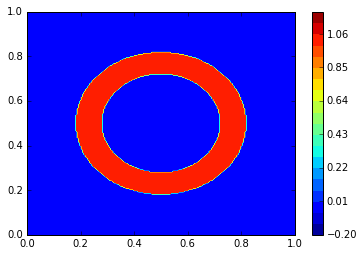

In [4]:
# First define our grid spacing
spacing = 0.005
dx2, dy2 = spacing**2., spacing**2.

a = 0.5  # Diffusion coefficient
# Derive timesteping
dt = dx2 * dy2 / (2 * a * (dx2 + dy2))
timesteps = 20

# Allocate two buffers and initialise ring
nx, ny = int(1 / spacing), int(1 / spacing)
u = np.zeros((2, nx, ny))
u[0, :] = ring_initial(spacing=spacing)
plot(u[0, :])

Now we can solve the problem with a set of Python loops, to illustrate how we would implement this simple stencil.

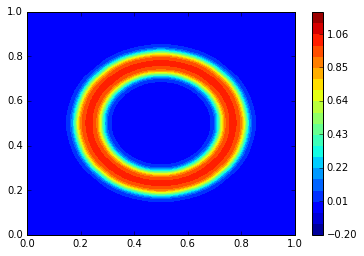

In [5]:
for ti in range(timesteps):
    t0 = ti % 2
    t1 = (ti + 1) % 2
    for i in range(1, nx-1):
        for j in range(1, ny-1):
            uxx = (u[t0, i+1, j] - 2*u[t0, i, j] + u[t0, i-1, j]) / dx2
            uyy = (u[t0, i, j+1] - 2*u[t0, i, j] + u[t0, i, j-1]) / dy2
            u[t1, i, j] = u[t0, i, j] + dt * a * (uxx + uyy)

plot(u[ti % 2, :, :])

Raw Python loops are know to be slow though, so we can use NumPy vectorisation to speed this up a little.

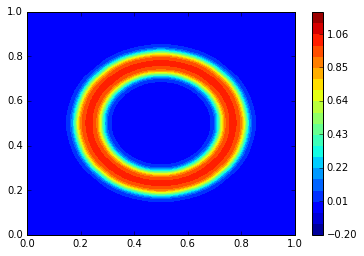

In [6]:
# Re-initialise buffers and ring
u = np.zeros((2, nx, ny))
u[0, :] = ring_initial(spacing=spacing)

for ti in range(timesteps):
    t0 = ti % 2
    t1 = (ti + 1) % 2
    # Vectorised version of the diffusion stencil
    uxx = (u[t0, 2:, 1:-1] - 2*u[t0, 1:-1, 1:-1] + u[t0, :-2, 1:-1]) / dx2
    uyy = (u[t0, 1:-1, 2:] - 2*u[t0, 1:-1, 1:-1] + u[t0, 1:-1, :-2]) / dy2
    u[t1, 1:-1, 1:-1] = u[t0, 1:-1, 1:-1] + a * dt * (uxx + uyy)

plot(u[ti % 2, :, :])

#### Symbolic implmentation in Devito
Writing out the stencil code for the equation is great fun, but it becomes cumbersome and error-prone once the equation and the spatial discretisation (stencil size) become complex and large. So instead we will let Devito figure out the stencil and let it generate bespoke code to solve our problem. For this, let's first allocate and initialise our data:

In [8]:
u = TimeData(name='u', shape=(nx, ny), time_order=1, space_order=2)
u.data[0, :] = ring_initial(spacing=spacing)
print u

u(t, x, y)


The `TimeData` object we created has a direct reference to the allocated data, which we can use to initialise our initial condition. The key thing to note though is that the created object `u` also behaves like a symbolic `sympy.Funtion` object:

In [9]:
from sympy import as_finite_diff
from sympy.abc import h, s
du_dx = as_finite_diff(u.diff(x), [x, x+h])
print du_dx

-u(t, x, y)/h + u(t, x + h, y)/h


It is worth noting here that the different instances of `u` all link back to the same object that olds our data:

In [10]:
print du_dx.args[0].args[1]
print du_dx.args[0].args[1].data.shape

u(t, x + h, y)
(2, 200, 200)


Devito also provides a short-hand notation for first and second derivative stencils in time and space, where the stencil order is determined by the `space_order` argument we gave the `TimeData` constructor above. This allows us to define our diffusion equation as:

In [11]:
from sympy import Eq, solve
eqn = Eq(u.dt, a * (u.dx2 + u.dy2))
print eqn

Eq(-u(t, x, y)/s + u(t + s, x, y)/s, -2.0*u(t, x, y)/h**2 + 0.5*u(t, x, y - h)/h**2 + 0.5*u(t, x, y + h)/h**2 + 0.5*u(t, x - h, y)/h**2 + 0.5*u(t, x + h, y)/h**2)


In [12]:
stencil = solve(eqn, u.forward)[0]
print stencil

0.5*(2.0*h**2*u(t, x, y) - 4.0*s*u(t, x, y) + s*u(t, x, y - h) + s*u(t, x, y + h) + s*u(t, x - h, y) + s*u(t, x + h, y))/h**2


GNUCompiler: Compiling /tmp/devito-1000/29518b1c9484711a7b1d38c782b89093b21a1608.cpp


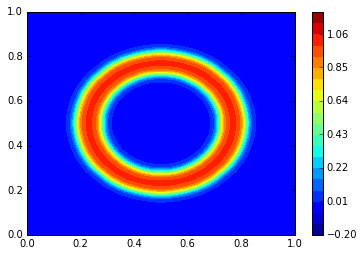

In [13]:
op = Operator(stencils=Eq(u.forward, stencil), subs={h: spacing, s: dt},
              nt=timesteps, shape=(nx, ny), spc_border=1, time_order=1)
result = op.apply()[0]
plot(result.data[0, :])

And this is the code that Devito produced:
```
extern "C" int Operator(float *u_vec)
{
  float (*u)[200][200] = (float (*)[200][200]) u_vec;
  {
    int t0;
    int t1;
    for (int i3 = 0; i3<20; i3+=1)
    {
      {
        t0 = (i3)%(2);
        t1 = (t0 + 1)%(2);
      }
      {
        for (int i1 = 1; i1<199; i1++)
        {
          #pragma GCC ivdep
          for (int i2 = 1; i2<199; i2++)
          {
            u[t1][i1][i2] = 1.11022302462516e-16F*u[t0][i1][i2] + 2.5e-1F*u[t0][i1][i2 - 1] + 2.5e-1F*u[t0][i1][i2 + 1] + 2.5e-1F*u[t0][i1 - 1][i2] + 2.5e-1F*u[t0][i1 + 1][i2];
          }
        }
      }
    }
  }
  return 0;
}
```